In [78]:
#현금 추가
tickers = ['코스피200', '해외채권', '원유', 'STOXX50', 'S&P500', '국내우량회사채', 'US Short']
tickers.append("현금")
#2020.11본원통화량을 시총으로 대입
caps.append(217700000000000)
#소비자물가지수에 의한 화폐가치 변화(직접적으로 알 수 있는 방법은 없음.) *영업일
price=[1.002]*19+[1.000]*22+[1.006]*23+[1.007]*20+[0.994]*21+[0.999]*19+[1.002]*21+[1.008]*22+[1.005]*20+[1.001]*18+[1.002]*22+[1.002]*21
prices.append(price) 

In [366]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from numpy.linalg import inv
import pandas as pd
from pandas_datareader import data as web
from scipy.optimize import minimize
from pykrx import stock
import matplotlib as mpl


In [346]:
# 무위험수익률, 수익률,공분산으로
# 샤프비율을 최대로 하는 접점포트폴리오 비중 계산 
def solveWeights(R, C, rf):
    
    # 파이썬은 함수안에 함수를 정의할 수 있다
    # 최적비중계산을 위해 다음과 같이 목적함수를 정의한다
    def obj(W, R, C, rf):
        mean = sum(R * W)
        var = np.dot(np.dot(W, C), W)
        #샤프비율을 효용함수로 한다
        util = (mean - rf) / np.sqrt(var) 
        # 효용함수 극대화= 효용함수 역함수를 최소화하는 것이다.
        return 1 / util  

    n = len(R)  # 투자자산 갯수

    # 동일비중으로 최적화 시작
    W = np.ones([n]) / n  
    # 비중범위는 0~100%사이(공매도나 차입조건이 없음)
    bnds = [(0., 1.) for i in range(n)]  
    # 제약조건은 비중합=100%
    cons = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.}) 
    # 최적화
    res = minimize(obj, W, (R, C, rf), method='SLSQP', constraints=cons, bounds=bnds)
    if not res.success:
      # 최적화 실패한 경우 
      raise BaseException(res.message)
    # 최적화 결과를 돌려준다  
    return res.x

In [347]:
# 무위험수익률, 수익률,공분산으로 효율적 프런티어 계산
def solveFrontier(R, C, rf):

    # 파이썬은 함수안에 함수를 정의할 수 있다
    # 최적비중계산을 위해 다음과 같이 목적함수를 정의한다
    def obj(W, R, C, r):
        # 주어진 수익률에서 분산을 최소로 하는 비중 계산
        mean = sum(R * W)
        var = np.dot(np.dot(W, C), W)
        # 최적화 제약조건 페널티
        penalty = 100 * abs(mean - r)             
        return var + penalty

    # 효율적 프론티어를 구성하는 평균-분산을 돌려줄
    # 리스트를 미리 준비한다
    frontier_mean, frontier_var = [], []

    n = len(R)  # 투자자산 갯수

    # 수익률 최저~최대 사이를 반복한다
    for r in np.linspace(min(R), max(R), num=20):
        # 최적화 함수에 전달할 초기값으로 동일비중으로 시작한다
        W = np.ones([n]) / n 

        # 최적화 함수에 전달할 범위조건과 제약조건을 미리 준비한다
        # 범위조건: 각 구성자산의 투자비중은 0~100% 사이이며
        # 제약조건: 전체 투자비중은 100%이다.
        bnds = [(0, 1) for i in range(n)]
        cons = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})
        
        # 최적화 함수 minimize()은 최적화할 obj함수와 
        # 최적화를 시작할 초깃값을 인수로 받는다.         
        res = minimize(obj, W, (R, C, r), method='SLSQP', constraints=cons, bounds=bnds)
        if not res.success:
            # 최적화에 실패한 경우
            raise BaseException(res.message)
        
        # 효율적 프런티어 평균과 분산리스트에 
        # 최적포트폴리오 수익률과 분산 추가
        frontier_mean.append(r)
        frontier_var.append(np.dot(np.dot(res.x, C), res.x))
    return np.array(frontier_mean), np.array(frontier_var)

In [348]:
# 효율적 포트폴리오 최적화        
def optimize_frontier(R, C, rf):

    # 접점포트폴리오 계산
    W = solveWeights(R, C, rf)
    # 투자비중으로 계산한 평균과 분산
    tan_mean = sum(R * W)
    tan_var = np.dot(np.dot(W, C), W)    

    # 효율적 포트폴리오 계산
    eff_mean, eff_var = solveFrontier(R, C, rf)

    # 비중, 접점포트폴리오의 평균/분산, 효율적 포트폴리오의 평균/분산을
    # 딕셔너리 데이터형으로 돌려준다    
    return {'weights':W, 'tan_mean':tan_mean, 'tan_var':tan_var, 'eff_mean':eff_mean, 'eff_var':eff_var}

In [349]:
# 자산에 대한 투자자의 전망과 전망의 기대수익률을 행렬로 만든다
def CreateMatrixPQ(names, views):
    r, c = len(views), len(names)

    # 투자전망과 기대수익률 행렬
    # views[i][3]에는 기대수익률을 가리킴
    Q = [views[i][3] for i in range(r)]     

    # 전망행렬 P를 만들기 위해
    # 구성자산 딕셔너리 작성
    nameToIndex = dict()    
    for i, n in enumerate(names):
        nameToIndex[n] = i

    # 투자전망 
    P = np.zeros([r, c]) 
    for i, v in enumerate(views):
        # 가령 전망이 ('MSFT', '>', 'GE', 0.02) 이라면
        # views[i][0] <-- 'MSFT' --> name1
        # views[i][1] <-- '>'
        # views[i][2] <-- 'GE'   --> name2
        # views[i][3] <-- '0.02'
        name1, name2 = views[i][0], views[i][2]
        P[i, nameToIndex[name1]] = +1 if views[i][1] == '>' else -1
        P[i, nameToIndex[name2]] = -1 if views[i][1] == '>' else +1
    return np.array(Q), P


In [350]:
---수정할 부분

SyntaxError: invalid syntax (<ipython-input-350-18595803b046>, line 1)

In [351]:
#단위 : 백만
#코스피200, 해외채권, 원유, STOXX50, S&P500, 금, 국내우량회사채, US Short
tickers=['069500','182490','130680','195930','143850','132030','136340','139660']
cap = {'069500':1980543000,'182490':7973560575,'130680':1884994000,
       '195930':4211956813,'143850':29087386767,'132030':11839175500, '136340':309950600 ,
       '139660':308523364
      }
prices, caps = [], []

for s in tickers:    
    pxclose = stock.get_market_ohlcv_by_date("20200529","20210531",s)['종가'].to_list()
    prices.append(pxclose)  
    caps.append(cap[s])

In [352]:
n = len(tickers)
W = np.array(caps) / sum(caps) # 시가총액의 비율계산
prices = np.matrix(prices)  # prices를 numpy matrix로 변환

# 수익률 행렬을 만들어 계산
rows, cols = prices.shape
returns = np.empty([rows, cols - 1])
for r in range(rows):
    for c in range(cols - 1):
        p0, p1 = prices[r, c], prices[r, c + 1]
        returns[r, c] = (p1 / p0) - 1

# 수익률계산
expreturns = np.array([])
for r in range(rows):
    expreturns = np.append(expreturns, np.mean(returns[r]))

# 공분산계산
covars = np.cov(returns)
R = (1 + expreturns) ** 250 - 1  # 연율화
C = covars * 250  # 연율화

# 무위험 이자율 (미국채 10년물)
rf = .0158

In [353]:
tickers

['069500',
 '182490',
 '130680',
 '195930',
 '143850',
 '132030',
 '136340',
 '139660']

In [368]:
#수익률과 시총가중치
tickers = ['KOSPI', 'GLBOND', 'OIL', 'STOXX50', 'S&P500', 'GOLD', 'KRBOND', 'US Short']
display(pd.DataFrame({'Return': R, 'Weight (based on market cap)': W}, index=tickers).T)

,KOSPI,GLBOND,OIL,STOXX50,S&P500,GOLD,KRBOND,US Short
Return,67.23%,11.89%,86.85%,35.37%,41.95%,8.41%,1.46%,10.62%
Weight (based on market cap),3.44%,13.84%,3.27%,7.31%,50.50%,20.56%,0.54%,0.54%


In [369]:
#공분산
display(pd.DataFrame(C, columns=tickers, index=tickers))

,KOSPI,GLBOND,OIL,STOXX50,S&P500,GOLD,KRBOND,US Short
KOSPI,4.43%,0.18%,2.61%,2.14%,2.51%,0.41%,0.01%,0.74%
GLBOND,0.18%,0.32%,0.29%,0.30%,0.21%,-0.07%,-0.00%,0.02%
OIL,2.61%,0.29%,10.69%,2.59%,2.76%,0.53%,-0.02%,0.66%
STOXX50,2.14%,0.30%,2.59%,3.37%,2.30%,-0.18%,0.00%,0.41%
S&P500,2.51%,0.21%,2.76%,2.30%,3.27%,0.52%,0.02%,0.55%
GOLD,0.41%,-0.07%,0.53%,-0.18%,0.52%,2.66%,-0.00%,0.35%
KRBOND,0.01%,-0.00%,-0.02%,0.00%,0.02%,-0.00%,0.01%,0.00%
US Short,0.74%,0.02%,0.66%,0.41%,0.55%,0.35%,0.00%,0.42%


In [370]:
# 1. 과거 데이터를 이용한 최적화
opt1 = optimize_frontier(R, C, rf)

In [371]:
# 2. 블랙-리터만 역최적화
# 포트폴리오 수익률 평균 및 분산
mean = sum(R * W)
var = np.dot(np.dot(W, C), W)

# lmbda: 위험회피계수 
lmbda = (mean - rf) / var  

# pi: 균형초과수익률
pi = np.dot(np.dot(lmbda, C), W)

In [372]:
#3. 균형기대수익률로 최적화 (총내재수익률 + 무위험수익률)
opt2 = optimize_frontier(pi+rf, C, rf)

In [373]:
#투자자 전망과 기대수익률 그리고 전망의 불확실성 계산
#view: 투자자 전망행렬 n=7, k=7
#절대적 전망: 코스피200, 해외채권, 원유, STOXX50, S&P500, 금, 국내우량회사채, US Short -> 1달뒤의 예상수익률
#상대적 전망: 시총고려, 선호순위 최대한 반영

Q = np.array([0.0121,
     0.0025,
     0.0294,
     0.0138,
     0.0135,
     0.0116,
     -0.00087,
     0.00065])
P = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 0, 0],
             [0, 0, 1, 0, 0, 0, 0, 0],
             [0, 0, 0, 1, 0, 0, 0, 0],
             [0, 0, 0, 0, 1, 0, 0, 0],
             [0, 0, 0, 0, 0, 1, 0, 0],
             [0, 0, 0, 0, 0, 0, 1, 0], 
             [0, 0, 0, 0, 0, 0, 0, 1],
            ])

# 위험조정상수 1/12
tau = .0833  

# 투자자 전망의 불확실성 계산
# tau * P * C * transpose(P)
omega = np.dot(np.dot(np.dot(tau, P), C), np.transpose(P))

In [374]:
Q.shape

(8,)

In [375]:
# 투자자 전망과 합쳐진 균형초과수익률 계산
bl1 = inv(np.dot(tau, C))
bl2 = np.dot(np.dot(np.transpose(P), inv(omega)), P)
bl3 = np.dot(inv(np.dot(tau, C)), pi)
bl4 = np.dot(np.dot(np.transpose(P), inv(omega)), Q)
pi_adj = np.dot(inv(bl1 + bl2), (bl3 + bl4))


In [376]:
opt3 = optimize_frontier(pi_adj + rf, C, rf)

In [377]:
from IPython.core.display import display, HTML
pd.options.display.float_format = '{:.2%}'.format

# 1번째 최적화 결과
display(HTML('<h2>Historical returns</h2>'))
display(pd.DataFrame({'Weight': opt1['weights']}, index=tickers).T)

# 2번째 최적화 결과
display(HTML('<h2>Implied returns</h2>'))
display(pd.DataFrame({'Weight': opt2['weights']}, index=tickers).T)

# 3번째 최적화 결과
display(HTML('<h2>Implied returns with adjusted views</h2>'))
display(pd.DataFrame({'Weight': opt3['weights']}, index=tickers).T)

,KOSPI,GLBOND,OIL,STOXX50,S&P500,GOLD,KRBOND,US Short
Weight,29.34%,57.00%,12.22%,0.00%,0.00%,1.44%,0.00%,0.00%


,KOSPI,GLBOND,OIL,STOXX50,S&P500,GOLD,KRBOND,US Short
Weight,3.10%,12.65%,2.99%,6.61%,45.33%,18.55%,10.36%,0.42%


,KOSPI,GLBOND,OIL,STOXX50,S&P500,GOLD,KRBOND,US Short
Weight,3.27%,15.27%,3.95%,8.30%,47.61%,21.60%,0.00%,0.00%


In [378]:
def plotAssets(tickers, R, C, color='black'):
    # 포트폴리오 구성자산 출력
    plt.scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color)  
    for i in range(n): 
        plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color) 

def plotFrontier(result, label=None, color='black'):
    # 최적화된 효율적 프런티어 출력
    plt.text(result['tan_var'] ** .5, result['tan_mean'], 'tangent', verticalalignment='center', color=color)
    plt.scatter(result['tan_var'] ** .5, result['tan_mean'], marker='o', color=color)
    plt.plot(result['eff_var'] ** .5, result['eff_mean'], label=label, color=color, linewidth=2, marker='D', markersize=9)

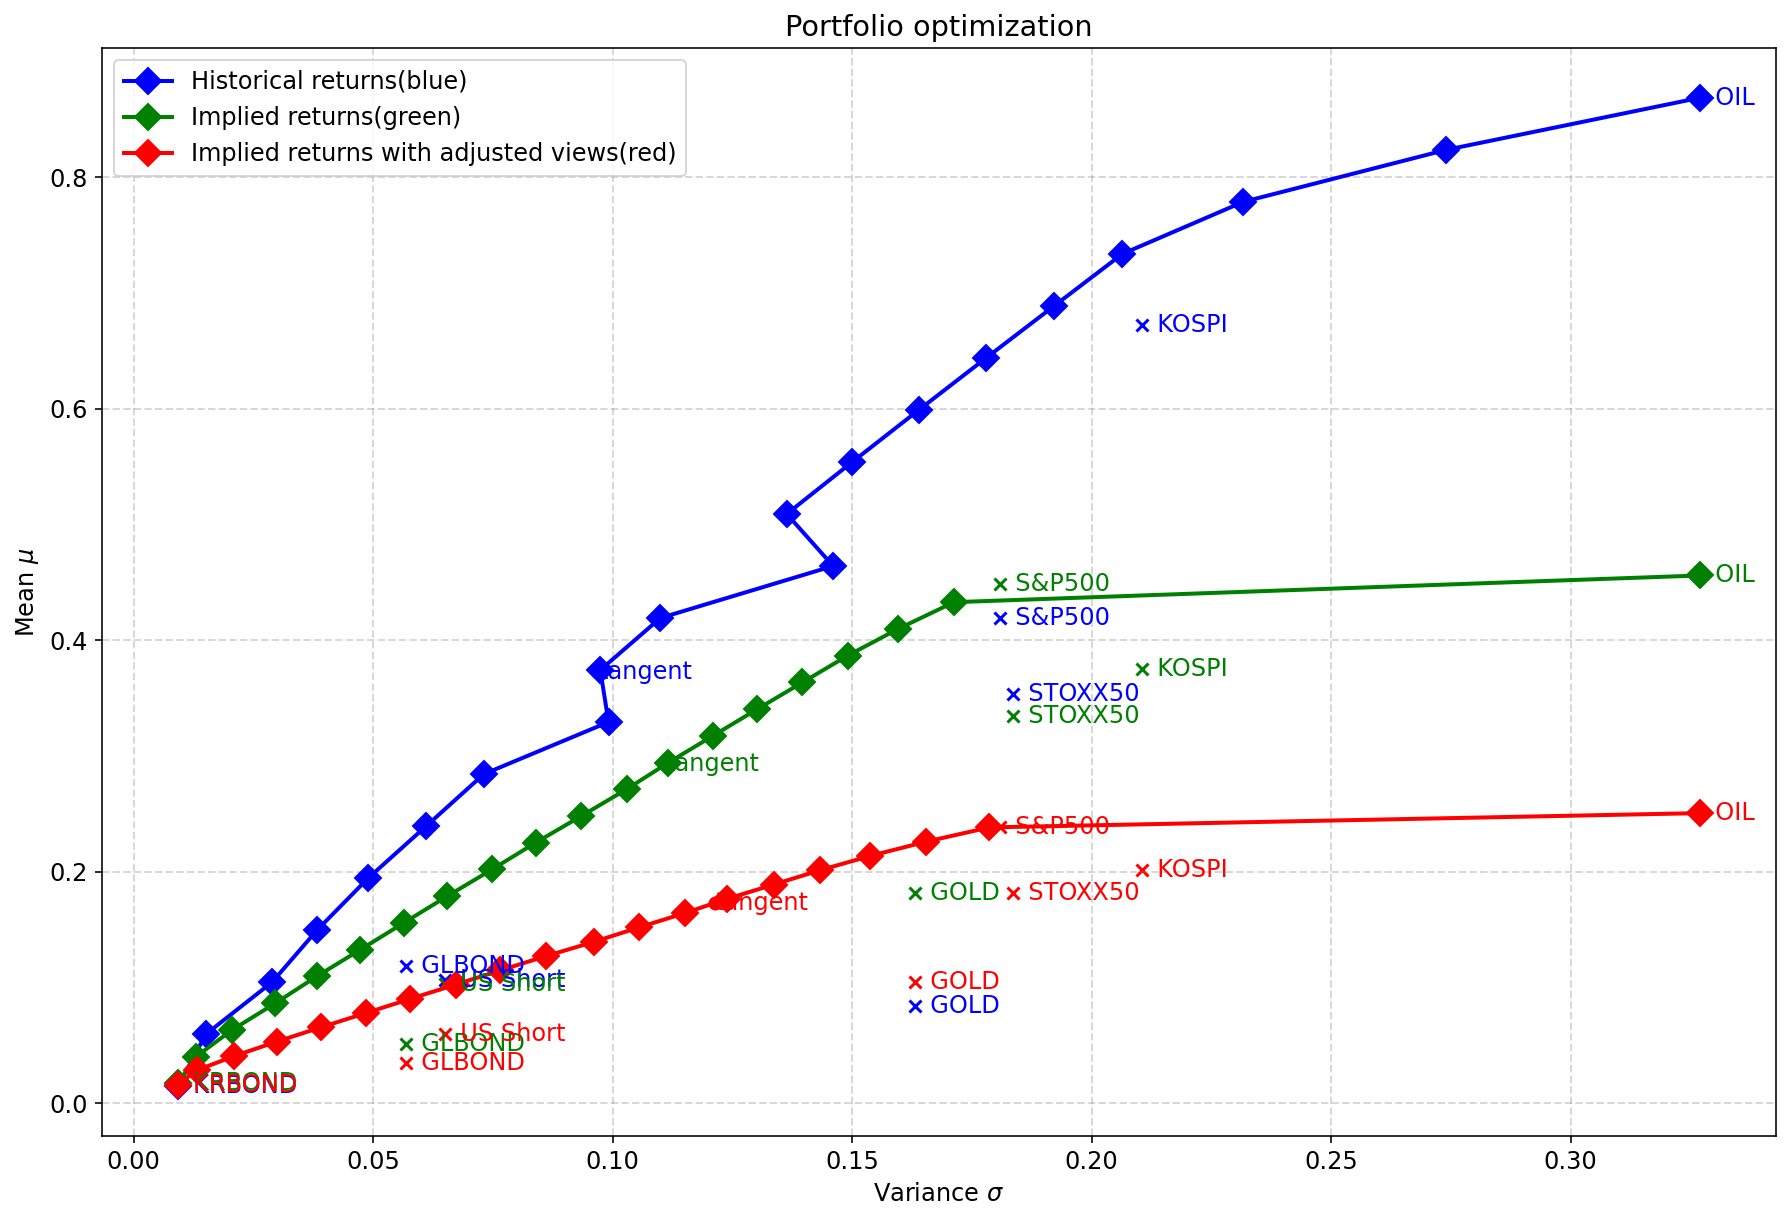

In [379]:

plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['xtick.labelsize'] = 12.
plt.rcParams['ytick.labelsize'] = 12.
plt.rcParams["figure.figsize"] = (15, 10)

# 1번째 최적화 결과를 차트로 출력
plotAssets(tickers, R, C, color='blue')
plotFrontier(opt1, label='Historical returns', color='blue')

# 2번째 최적화 결과를 차트로 출력
plotAssets(tickers, pi+rf, C, color='green')
plotFrontier(opt2, label='Implied returns', color='green')

# 3번째 최적화 결과를 차트로 출력
plotAssets(tickers, pi_adj+rf, C, color='red')
plotFrontier(opt3, label='Implied returns (adjusted views)', color='red')

# 차트에 공통된 속성을 지정한다(차트크기, 제목, 범례, 축이름 등)

plt.grid(alpha=0.3, color='gray', linestyle='--', linewidth=1)
plt.title('Portfolio optimization')
plt.legend(['Historical returns(blue)', 'Implied returns(green)','Implied returns with adjusted views(red)'])
plt.xlabel('Variance $\sigma$')
plt.ylabel('Mean $\mu$')
plt.show()